# Hidden Markov models

## Principles

In a hidden Markov model (HMM), the sequence of $T$ output variables ${y_t}$ is generated by a parallel sequence of latent categorical state variables $z_t \in \left\{ 1,\cdots , K\right\}$. These hidden states are a Markov chain, so that $z_t$ is conditionally independent of other variables given $z_{t-1}$.

```{figure} /figures/tikz_hmm.png
---
name: tikzhmm
width: 250px
align: center
---
Hidden Markov model. Grey nodes denote the observed output sequence; white nodes denote the hidden states. Hidden states are conditioned on each other, while each observation is only conditioned on the current state
```

The primary use of HMMs in building energy simulation is for identifying and modelling occupancy {cite:p}`candanedo2017methodology`. The hidden variable $z_t$ may denote a binary state of occupancy or a finite number of occupants; the observed output $y_t$ may denote any measurement impacted by occupancy: environmental sensors, smart meters, cameras, infrared sensors... There is a vast literature on occupancy detection and estimation from different types of data and methods. The reader is referred to the review of Chen et al {cite:p}`chen2018building` for a more comprehensive insight.

A HMM is defined by:

* A sequence of hidden states $\left\{z_t\right\} \in \mathbb{N}^T$, each of which can take a finite number of values: $z_t \in \left[1,...,K\right]$
* An observed variable $\left\{y_t\right\} \in \mathbb{R}^T$
* An initial probability $\pi_0$ which is the likelihood of the state at time $t=0$. $\pi_0$ is a $K$-simplex, i.e. a $K$-vector which components sum to 1.
* A $K\times K$ one-step transition probability matrix $\mathbf{A}(t) = \left(a_{ij}(t)\right)$ so that
```{math}
:label: hmm1
a_{ij}(t)=p\left(z_t=j |z_{t-1}=i\right)
```
is the probability at time $t$ for the hidden variable to switch from state $i$ to state $j$. Like $\pi_0$, each row of $\mathbf{A}(t)$ must sum to 1.
* Emission probabilities $b_{i}(y_t) = p(y_t | z_t=i)$, i.e. the probability distribution of the output variable given each possible state.

The transition probabilities $\left(a_{ij}(t)\right)$ are shown here as functions of time because they can be formulated as parametric expressions of external observed variables, such as the time of the day or weather variables. The Markov chain is then called *inhomogeneous*. Inhomogeneous transition probability matrices can capture occupancy properties at different time instances and thus encode occupancy dynamics: there can a higher probability of people entering the building at a certain time of the day, or if the outdoor temperature is high, etc.

**Training** an HMM means finding the set of parameters $\theta$ which best explain the observations. This can be done by in least two ways: the first option is to compute the likelihood function with the forward algorithm, explained below, and to perform its direct numerical maximization. The second option is the Baum-Welch algorithm, a special case of the expectation-maximization (EM) algorithm: it alternates between a forward-backward algorithm for the expectation step, and an updating phase for the maximization step.

A trained HMM can then be used to predict states and future values of the outcome variable. The estimation of the most likely state sequence given the observations is called **decoding**.

```{math}
:label: hmm2
z^*_{0:T} = \mathrm{arg max}_z \; p(z_{0:T} | y_{0:T})
```

and can be done by the Viterbi algorithm described below.

### The forward algorithm

The forward algorithm computes the likelihood function $p(y_{1:T}|\theta)$ of a hidden Markov model, given the values of its parameters $\theta$. These parameters come from the parametric expressions of $\pi_0$, $a_{ij}(t)$ and $b_{i}$.

The algorithm works by calculating the components of a $[T \times K]$ matrix $\alpha$ of *forward variables* defined by:

```{math}
:label: hmm3
\alpha_{ij} = p(y_{0:i},z_i=j)
```

The forward variable $\alpha_{ij}$ is the joint probability of observations up to time $i$, and of the current hidden variable $z_i$ being in state $j$. The $\alpha$ matrix is filled row by row, and the total likelihood of the data is the sum of its last row.

```{figure} /figures/algo_forward.png
---
name: algoforward
width: 600px
align: center
---
Forward algorithm for computing the likelihood of the data $y_{1:T}$ given the parameters of a HMM
```

### The Viterbi algorithm

Supposing a trained HMM with known parameters in the initial probability $\pi_0$, transition matrix $\mathbf{A}(t)$ and emission probabilities $\mathrm{b}(y)$; the Viterbi algorithm finds the best sequence of hidden states, so that their probability conditioned on the data $y_{0:T}$ is at a maximum:

```{math}
:label: hmm4
z^*_{0:T} = \mathrm{arg max}_z \; p(z_{0:T} | y_{0:T})
```

This process is called global decoding, and one of the possible inferences from HMMs.

The Viterbi algorithm looks similar to the backward algorithm, with an additional backtracking phase. It produces two $[T \times K]$ matrices $\delta$ and $\psi$ and fills them row by row in a forward phase. Then, a backtracking phase computes $z^*_{0:T}$ from the $\psi$ matrix. The algorithm is described with more detail [here](https://medium.com/@Ayra_Lux/hidden-markov-models-part-2-the-decoding-problem-c628ba474e69).

```{figure} /figures/algo_viterbi.png
---
name: algoviterbi
width: 600px
align: center
---
The Viterbi algorithm finds the best sequence of hidden states $z_{0:T}$ given observations $y_{0:T}$
```

## Tutorial

Hidden Markov models are also covered [in the Stan user's guide](https://mc-stan.org/docs/stan-users-guide/hmms.html).


The data comes from [Building 1298 from the ASHRAE Kaggle competition](building1298), specifically meter 0 (electricity). This tutorial implements a simple homogeneous HMM written in Python and **doesn't use Stan** for once. The point is to show how to code the forward algorithm and the Viterbi algorithm from scratch.

Let us start by importing some libraries, reading the data file and selecting which variable will be the dependent variable of our model.

/tmp/ipykernel_3657/660712787.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


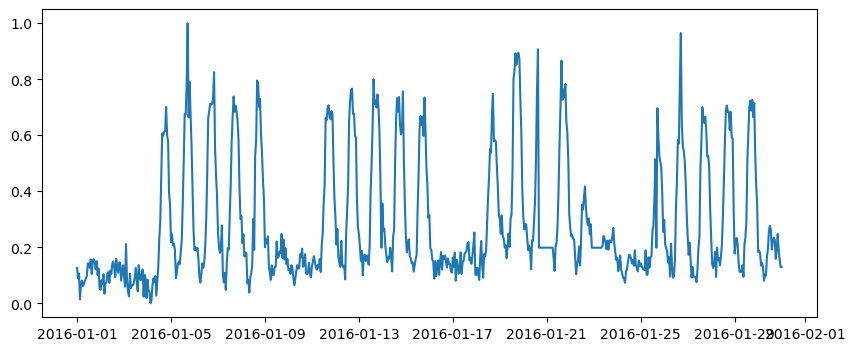

In [6]:
# importing the three main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# importing parts of scipy
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.stats import norm

# Reading the data file
df = pd.read_csv('data/building_1298.csv')
df.set_index(pd.to_datetime(df['datetime']), inplace=True, drop=True)
df.fillna(method='ffill', inplace=True)

# Selecting a training subset
training_start = '2016-01-01'
training_end = '2016-01-31'
df_train = df.drop(df.index[(df.index < pd.to_datetime(training_start)) |(df.index > pd.to_datetime(training_end))])

# choosing meter 0 as dependent variable
df_train['y'] = df_train['m0']
# removing some outliers
df_train.loc[df_train['m0'] < 300, 'y'] = df_train['m0'].mean()
# normalizing y between 0 and 1
df_train['y'] = (df_train['y'] - df_train['y'].min()) / ( df_train['y'].max() - df_train['y'].min() )

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df_train.index, df_train['y'])

The forward algorithm described above is written here. At any of the $N$ time steps, the Markov chain can take one of $K$ states. We assume that the emission probabilities are Normal with means $\mu_i$ and standard deviations $\sigma_i$:

```{math}
:label: hmm11
b_i(y_t) = p(y_t|z_t=i) = N(\mu_i, \sigma_i)
```

The parameters of the forward algorithm are the transition matrix $a$, and the parameters of the emission probabilities $\mu$ and $\sigma$:

In [7]:
def forward(y, a, mu, sig):
    """ Calculates the likelihood from parameters a, mu and sig
    Arguments:
        y: dependent variable [N]
        a: transition matrix [KxK]
        mu: emission means [K]
        sig: emission standard deviations [K]
    Returns:
        The total log-likelihood
    """
    N = len(y)
    logalpha = np.zeros((N,K)) # log of the forward variable defined above
    # Initialisation
    pi0 = 1/K * np.ones(K)  # initial probabilities. Supposed known here.
    logalpha[0] = np.log(pi0) + norm.logpdf(y[0], loc=mu, scale=sig)
    # Recursion
    for t in range(1, N):
        for j in range(K):
            logalpha[t,j] = logsumexp(logalpha[t-1,:] + np.log(a[:,j]) + norm.logpdf(y[t],
                            loc=mu[j], scale=sig[j]) )
    # Termination
    return logsumexp(logalpha[-1])

The next block uses this forward algorithm to train the HMM. Just like in the ARMAX example, we only use a one-month subset of the whole training dataset. 

Training is done by the scipy.minimize() function. Before using it, we need to define an objective function to minimize. This function will take a single array $x$ as argument and return the value we aim to minimize, which is the negative log likelihood from the forward algorithm.

In [8]:
def objective(x):
    # Reshaping the parameter vector x into the three variables of the forward algorithm
    a1 = np.reshape(x[:K*(K-1)], (K,K-1))   # Matrix a without the right column
    a2 = (1-a1.sum(axis=1))[:,np.newaxis]   # Right column of matrix a
    a = np.concatenate([a1, a2],axis=1)
    mu = x[K*(K-1):K*(K-1)+K]
    sig = x[K*(K-1)+K:]
    # Returns the minus log likelihood
    return -forward(df_train['y'], a, mu, sig)

# Initial parameter values to be passed to scipy.minimize()
K = 2                           # number of possible states
a_init = np.array([[0.9],[0.1]])
mu_init = [0.2, 0.6]     # emission means
sig_init = [0.1, 0.1]    # emission standard deviations

# Parameters are assembled into a single array x with given bounds
x0 = np.concatenate( [a_init.flatten(), mu_init, sig_init] )
bounds = (K*(K-1)*[(0,1)] + 2*K*[(0, None)])

# Training
res = minimize(objective, x0, bounds=bounds)

# Variables are recovered from the fitted x array
a1 = np.reshape(res.x[:K*(K-1)], (K,K-1))
a2 = (1-a1.sum(axis=1))[:,np.newaxis]
a = np.concatenate([a1, a2],axis=1)
mu = res.x[K*(K-1):K*(K-1)+K]
sig = res.x[K*(K-1)+K:]

/tmp/ipykernel_3657/3848433432.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  logalpha[0] = np.log(pi0) + norm.logpdf(y[0], loc=mu, scale=sig)
/tmp/ipykernel_3657/3848433432.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  logalpha[t,j] = logsumexp(logalpha[t-1,:] + np.log(a[:,j]) + norm.logpdf(y[t],


Now that the parameters of the HMM have been estimated, we can decode it, i.e. estimating the most likely state sequence. This is done by the Viterbi algorithm below.

In [9]:
y = df_train['y']
N = len(y)

z = np.zeros(N)  # hidden state to be determined
best_logp = np.zeros((N, K))  # delta in the description above
back_ptr = np.zeros((N, K))  # psi in the description above

# Initialisation
best_logp[0] = norm.logpdf(y[0], loc=mu, scale=sig)

# Recursion
for t in range(1, N):
    for k in range(K):
        logp = best_logp[t - 1] + np.log(a[:, k]) + norm.logpdf(y[t], loc=mu[k], scale=sig[k])
        best_logp[t, k] = np.max(logp)
        back_ptr[t, k] = np.argmax(logp)
        
# Backtracking
z[-1] = np.argmax(best_logp[-1])
for t in range(1, N):
    z[-1 - t] = back_ptr[-1 - t + 1, int(z[-1 - t + 1])]

/tmp/ipykernel_3657/3753217930.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_logp[0] = norm.logpdf(y[0], loc=mu, scale=sig)
/tmp/ipykernel_3657/3753217930.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  logp = best_logp[t - 1] + np.log(a[:, k]) + norm.logpdf(y[t], loc=mu[k], scale=sig[k])


We can finish by inferring the predicted output from the estimated states and parameters of the HMM.

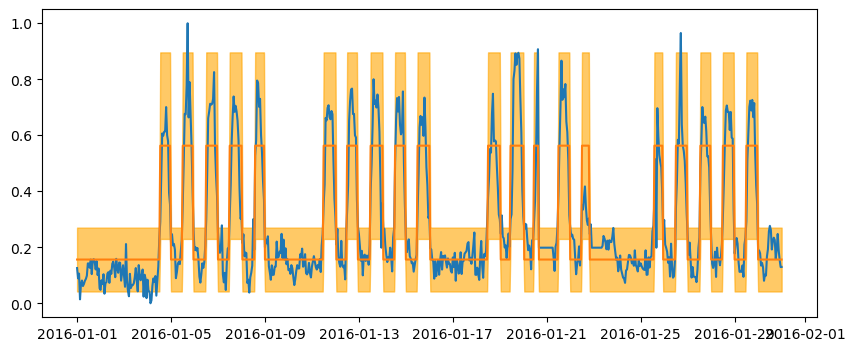

In [10]:
y_star_mean = np.zeros(N)
y_star_std = np.zeros(N)
for k in range(K):
    y_star_mean[z == k] = mu[k]
    y_star_std[z == k] = sig[k]

y_star = np.random.normal(loc=y_star_mean, scale=y_star_std)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df_train.index, df_train['y'])
ax.plot(df_train.index, y_star_mean)
ax.fill_between(df_train.index, y_star_mean-1.96*y_star_std, y_star_mean+1.96*y_star_std, color='orange', alpha=0.6)

## Composite time series models

### Markov switching models

Following the definitions of autoregressive models and hidden Markov models, a natural extension is a combination of both: a time-series model where the observed variable $y_t$ is explained by a hidden state $x_t$ and by a regression of its own previous value $y_{t-1}$. These models are called autoregressive hidden Markov models (AR-HMM) {cite:p}`murphy2002dynamic` or Markov switching models (MSM) {cite:p}`wolf2019markov`.

```{figure} /figures/tikz_msm.png
---
name: tikzmsm
width: 250px
align: center
---
Markov switching model
```

Similar to an HMM, an MSM is defined by a matrix of transition probabilities $\left(a_{ij}(t)\right) = p\left(z_t=j |z_{t-1}=i\right)$ whose terms can be conditioned on explanatory variables (time, day, weather...) and by emission probabilities. Rather than being only conditioned on $x_t$, the emission probability can be a function of previous observations. This is an example of AR(1) process:

```{math}
:label: msm1
p(y_t | z_t=j) = \alpha_j + \phi_j y_{t-1} + w_{t,j}
```

where the intercept $\alpha_j$, slope $\phi_j$ and noise $w_{t,j}$ depend on the state $z_t$, and may have as many different values as the number of possible states. In a more complicated example, one could implement a whole ARMAX model into the observation probability of a Markov switching model.

An MSM can be trained with the same Baum-Welch algorithm and decoded with the same Viterbi algorithm as an HMM. The only difference is in the expression of the emission probabilities, which do not change the structure of the algorithms because $y_t$ is conditionally independent on $x_{t-1}$ given $x_t$ and $y_{t-1}$.

### Hidden Markov energy signature

Another extension of the HMM structure was [proposed by the author](https://doi.org/10.3390/en15103534) {cite:p}`rouchier2022bayesian` and called hidden Markov energy signature model. It is a HMM where the emission probability functions are energy signature (ES) models (see chapter \@ref(bayesianmv)):

* The energy use $y_t$ of a building at time $t$ follows a different ES model for each possible occupancy state $z_t \in \left[1,...,K\right]$. This is how we allow the parameters of the ES model $\left\{E_0, T_1, T_2, H_1, H_2, \sigma\right\}$ to depend on the occupancy.
```{math}
:label: msm2
b_{i}(y_t) = p(y_t|\theta, T_a, z_t=i) = N\left[E_{0,i} + H_{1,i}\left(T_{1,i}-T_a\right)^+ + H_{2,i}\left(T_a-T_{2,i}\right)^+, \sigma_i \right]
```
* The occupancy state at each time $t$ is unknown, and described by a hidden Markov chain. We define a transition probability matrix for each hour of the day $h$ and day of the week $d$
```{math}
:label: msm3
a_{ij}(h,d)=p\left(z_{h,d}=j |z_{h-1,d}=i\right)
```

This formulation can be described as follows: at every hour $h$ and day $d$, the building has a probability $a_{ij}(h,d)$ to switch from the occupancy state $i$ to state $j$. Then, if the building is in the occupancy state $i$, then its energy use follows one of $K$ possible ES models $b_i(y_t)$.